## Experiment 1: Titanic Dataset
### COGS118A - Final Project
### by Justin Laughlin and Stuart Sonatina

In [1]:
# import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# splitting, training, and testing
import sklearn.model_selection as ms
#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score

# Principle component analysis
from sklearn.decomposition import PCA

# random forest classifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import sklearn.metrics as skm

# magic command to display plots inline
%matplotlib inline

### Features of "titanic.csv":

| Variable | Definition | Key |
|---|---|---|
|survival | Survival | 0 = No, 1 = Yes |
|pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
|sex | Sex | 0 = Male, 1 = Female|
|Age | in years	| |
|sibsp | # of siblings / spouses aboard the Titanic | |	
|parch | # of parents / children aboard the Titanic	 | |
|ticket | Ticket number	| |
|fare |Passenger fare | |
|cabin | Cabin number | |
|embarked |	Port of Embarkation	| C = Cherbourg, Q = Queenstown, S = Southampton |

Source: [Kaggle](https://www.kaggle.com/c/titanic/data)


In [2]:
# Setting parameters
trainTestSplit = [0.4, 0.6, 0.8]
nfold = 10
ntrees = 1000
# (https://matplotlib.org/users/colormaps.html)
colorMap = 'GnBu'

In [3]:
# Use pandas to import data into dataframe. PassengerID is redundant
df = pd.read_csv('titanic.csv')
df.drop('PassengerId', axis=1, inplace=True)

In [4]:
# class label == survival
Y = df.as_matrix(columns=['Survived']).reshape([-1,1]).ravel()

# Delete Name, Ticket and Cabin features, along with class label and encoded features
Xdf = df.drop(['Name', 'Ticket', 'Cabin', 'Survived', 'Embarked'], axis=1)

# Convert NaN to mean age
Xdf.fillna(np.mean(Xdf['Age']), inplace=True)

# One-hot encode port embarked from
PortEncoded = pd.get_dummies(df['Embarked'])
Xdf['EmbCherb'] = PortEncoded['C']
Xdf['EmbQueen'] = PortEncoded['Q']
Xdf['EmbSouth'] = PortEncoded['S']

# replace male/female with 0/1 respectively
Xdf['Sex'].replace(['male','female'],[0.,1.],inplace=True)

num_samples, num_features = Xdf.shape

In [5]:
# Look at first 6 passengers
Xdf[:6]

,Pclass,Sex,Age,SibSp,Parch,Fare,EmbCherb,EmbQueen,EmbSouth
0,3,0.0,22.000000,1,0,7.2500,0,0,1
1,1,1.0,38.000000,1,0,71.2833,1,0,0
2,3,1.0,26.000000,0,0,7.9250,0,0,1
3,1,1.0,35.000000,1,0,53.1000,0,0,1
4,3,0.0,35.000000,0,0,8.0500,0,0,1
5,3,0.0,29.699118,0,0,8.4583,0,1,0


## Data Exploration

Score for 'Female survived': 78.7%


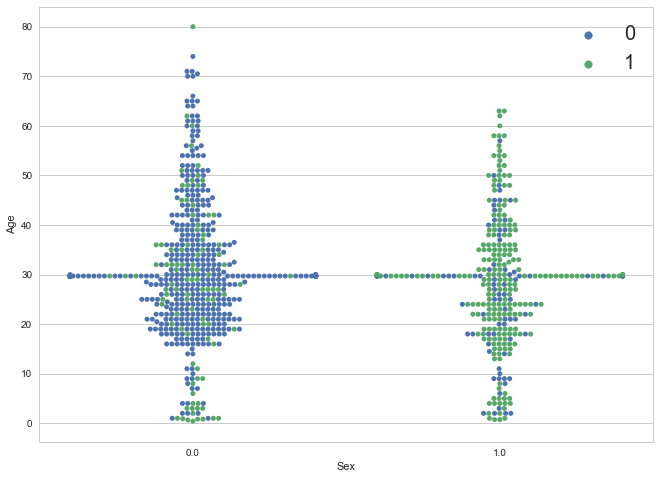

In [6]:
# Male/Female vs age
# wideform dataframe
age_vs_sex = pd.DataFrame.from_dict({'Sex':Xdf['Sex'], 'Age':Xdf['Age'], 'Survived':df['Survived']})

# Draw a categorical scatterplot to show each observation
fig, ax = plt.subplots()
fig.set_size_inches(11,8)
sns.set()
sns.set(font_scale=1.5)
sns.swarmplot(x="Sex", y="Age", hue="Survived", data=age_vs_sex)
plt.legend(prop={'size':20})

print("Score for 'Female survived': {:.1f}%".format((np.sum(df['Survived']==Xdf['Sex'])/num_samples)*100))

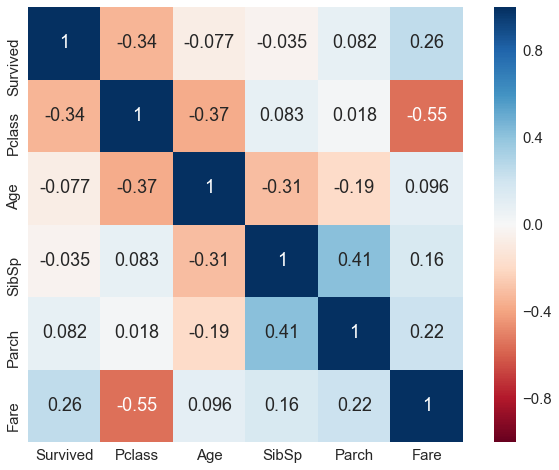

In [7]:
# Plot correlation matrix
plt.figure(figsize=(11,8))
sns.heatmap(df.corr(),square=True,annot=True,cmap="RdBu")

## Feature Engineering

In [8]:
# Save a copy of Xdf before feature engineering so it can be compared
Xdf_nofe = Xdf.copy(deep=True)

In [9]:
# If individual is under 18 and Parch>=1 individual is a child with parent(s) on board
Xdf["ChwPar"] = ((Xdf["Age"]<=18) & (Xdf["Parch"]>=1)) * Xdf["Parch"]
# If individual is over 18 and Parch>=1 individual is a parent with children on board
Xdf["ParwCh"] = ((Xdf["Age"]>18) & (Xdf["Parch"]>=1)) * Xdf["Parch"]
# Drop the feature "Parch" as it has been split into two different features
Xdf = Xdf.drop(["Parch"], axis=1)

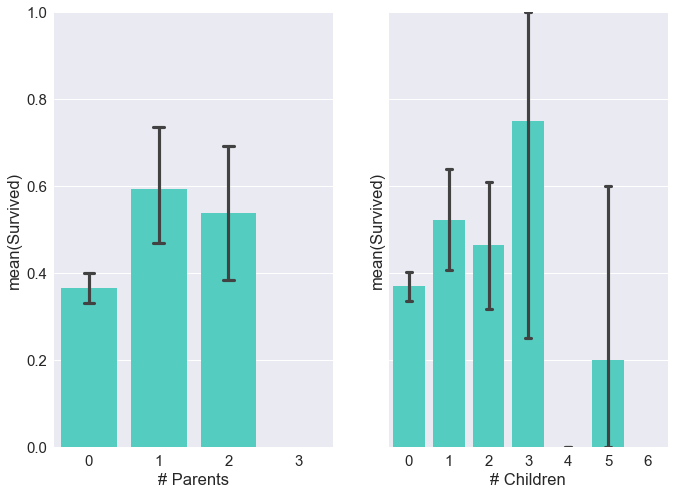

In [10]:
# Extract ChwPar and ParwCh from dataframes
ChwPar = pd.DataFrame.from_dict({'# Parents':Xdf['ChwPar'], 'Survived':df['Survived']})
ParwCh = pd.DataFrame.from_dict({'# Children':Xdf['ParwCh'], 'Survived':df['Survived']})

# Setting up plot environment
alph = 5 # significance level [%] for confidence intervals
cs = 0.15 # capsize for confidence interval tips
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True)
fig.set_size_inches(11,8)
ax1.set_ylim(0,1)
sns.set()
sns.set(font_scale=1.5)

# Draw a barplot for ChwPar
sns.barplot(x="# Parents", y="Survived", data=ChwPar, ax=ax1, color = "turquoise", ci=100-alph, capsize=cs)

# Draw a barplot for ParwCh
sns.barplot(x="# Children", y="Survived", data=ParwCh, ax=ax2, color = "turquoise", ci=100-alph, capsize=cs)

In [11]:
# Different titles with frequency of each
titles = df['Name'].str.split(", ", expand=True)[1].str.split(". ", expand=True)[0]
titles.groupby(titles).count()

0
Capt          1
Col           2
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
th            1
Name: 0, dtype: int64

In [12]:
# Removing "Name" column and converting into individual features based on rare names
rareTitles = ["Master", "Dr", "Rev"]
for i in np.arange(len(rareTitles)):
    Xdf[rareTitles[i]] = df["Name"].str.contains(", " + rareTitles[i]).astype(int)

In [13]:
titleSurvival = {}
ntitles = 0
print("\t\tNumber of Individuals \t | Mean Survival")
for i in np.arange(len(rareTitles)):
    # Find mean survival of passengers with rare title
    titleSurvival[rareTitles[i]] = (df[Xdf[rareTitles[i]]==1])["Survived"]
    ntitles = ntitles + len(titleSurvival[rareTitles[i]])
    print(rareTitles[i],"\t\t",len(titleSurvival[rareTitles[i]]),"\t\t\t |","{0:.3f}".format(np.mean(titleSurvival[rareTitles[i]])))
print("No Rare Title\t",num_samples - ntitles,"\t\t\t |","{0:.3f}".format(df.mean()["Survived"]))

		Number of Individuals 	 | Mean Survival
Master 		 40 			 | 0.575
Dr 		 7 			 | 0.429
Rev 		 6 			 | 0.000
No Rare Title	 838 			 | 0.384


In [14]:
Xdf.head()

,Pclass,Sex,Age,SibSp,Fare,EmbCherb,EmbQueen,EmbSouth,ChwPar,ParwCh,Master,Dr,Rev
0,3,0.0,22.0,1,7.2500,0,0,1,0,0,0,0,0
1,1,1.0,38.0,1,71.2833,1,0,0,0,0,0,0,0
2,3,1.0,26.0,0,7.9250,0,0,1,0,0,0,0,0
3,1,1.0,35.0,1,53.1000,0,0,1,0,0,0,0,0
4,3,0.0,35.0,0,8.0500,0,0,1,0,0,0,0,0


## Training Classifier

In [15]:
Xdf_nofe.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,EmbCherb,EmbQueen,EmbSouth
0,3,0.0,22.0,1,0,7.2500,0,0,1
1,1,1.0,38.0,1,0,71.2833,1,0,0
2,3,1.0,26.0,0,0,7.9250,0,0,1
3,1,1.0,35.0,1,0,53.1000,0,0,1
4,3,0.0,35.0,0,0,8.0500,0,0,1


In [16]:
# Function which performs a grid search to estimate the best parameters and 
# plots the heatmap of scores vs. parameters
def gridSearchAndPlot(estimator, Xtrain, Ytrain):
    
    # grid search
    clf = ms.GridSearchCV(estimator, parameters, cv=nfold)
    clf.fit(Xtrain, Ytrain)
    # print(clf.best_params_)
    cvScores = clf.cv_results_["mean_test_score"].reshape([a,b])
    
    # plot
    plt.figure()
    plt.pcolor(parameters['min_samples_split'], parameters['max_features'], cvScores, cmap=colorMap)
    plt.colorbar()
    plt.xlabel('Min Samples to Split')
    plt.ylabel('Max number of Features Considered')
    plt.xticks(parameters['min_samples_split'])
    plt.yticks(parameters['max_features'])
    plt.title('Cross Validation Scores vs Hyperparameters')
    
    # return classifier
    return clf

In [17]:
# F-score provides a useful balance between precision and recall
# By definition: F = 2*(precision*recall)/(precision+recall)
def calcFscore(clf,Xtest,Ytest):
    # Calculate score 
    Yscore = clf.predict(Xtest)

    precision, recall, thresholds = skm.precision_recall_curve(Ytest, Yscore, pos_label=1)
    skm.classification_report(Ytest, Yscore,target_names=['Didn\'t Survive', 'Survived'])
    F = 2*(precision[1]*recall[1])/(precision[1]+recall[1])

    # Print results
#     print("Precision: \t{}".format(precision))
#     print("Recall: \t{}".format(recall))
#     print("Thresholds: \t{}".format(thresholds))
#     print(F)
    
    # return
    return (precision,recall,F)

In [18]:
# Initialize stuff for classifier

# dictionary of classifiers and scores (precision, recall, and F-score)
clf = {}
scores = {"precision":{},"recall":{},"F":{}}

# train a random forest classifier on our training set
rand_forest = RandomForestClassifier(n_estimators=ntrees)

# use GridSearchCV to tune the following hyperparameters:
# min_samples_split == minimum samples in node to perform a split
# max_features == max number of features used to perform a split
parameters = {'min_samples_split':[2,3,4,5,6,7,8], 'max_features':[1,2,3,4,5,6,7]}
b = len(parameters['min_samples_split'])
a = len(parameters['max_features'])

Perform a grid search with 7*7 different parameters with 3 different train/test splits. 

This is done on a random forest classifier with 1000 trees. This will take ~30-40 mins.


Train/Test Split: 0.4/0.6
Optimal Max Features = 	5
Optimal Min Samples  = 	7

Train/Test Split: 0.6/0.4
Optimal Max Features = 	3
Optimal Min Samples  = 	5

Train/Test Split: 0.8/0.2
Optimal Max Features = 	7
Optimal Min Samples  = 	8


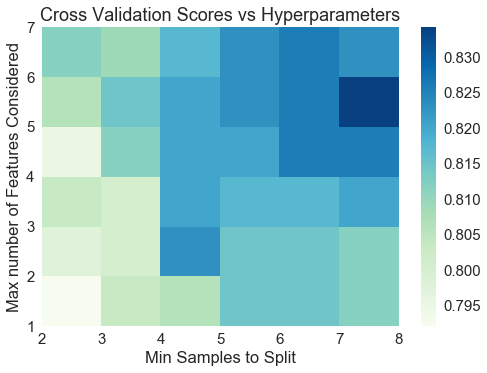

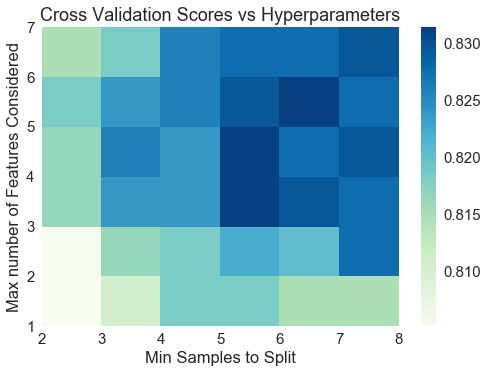

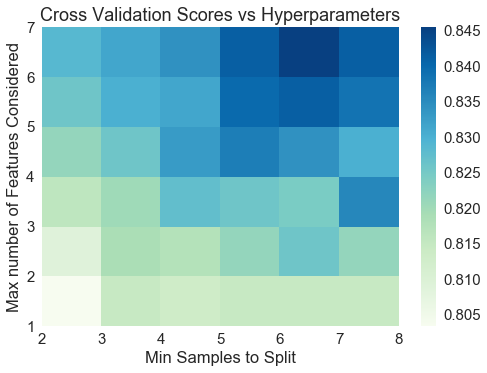

In [19]:
# turn that dataframe into a numpy array
X = Xdf.as_matrix()

# split into training and test set
for trainSplit in trainTestSplit:
    [Xtrain, Xtest, Ytrain, Ytest] = ms.train_test_split(X, Y, train_size=trainSplit)
    scoresKey = str(trainSplit*100)[:2]
    clfKey = "Xdf_"+str(trainSplit*100)[:2]
    clf[clfKey] = gridSearchAndPlot(rand_forest,Xtrain,Ytrain)
    #(scores["precision"][scoresKey],recall["recall"][scoresKey],scores["F"][scoresKey]) = calcFscore(clf[clfKey],Xtest,Ytest)
    #print("Best parameters for trainTestSplit =",trainSplit,clf[clfKey].best_params_)
    
    print("\nTrain/Test Split: {:.1f}/{:.1f}".format(trainSplit, 1-trainSplit))
    print("Optimal Max Features = \t{}".format(clf[clfKey].best_params_["max_features"]))
    print("Optimal Min Samples  = \t{}".format(clf[clfKey].best_params_["min_samples_split"]))

NotFittedError: Estimator not fitted, call `fit` before exploiting the model.

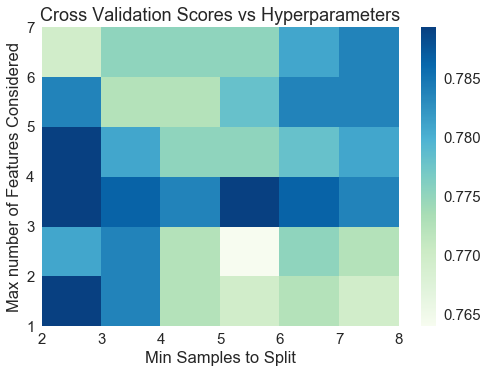

In [20]:
# turn that dataframe into a numpy array
X = Xdf_nofe.as_matrix()

# split into training and test set
for trainSplit in trainTestSplit:
    [Xtrain, Xtest, Ytrain, Ytest] = ms.train_test_split(X, Y, train_size=trainSplit)
    gridSearchAndPlot(rand_forest,Xtrain,Ytrain)
    calcFscore(rand_forest, Xtest, Ytest)